In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


time_step = 10

# 모델 생성 함수
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
df = pd.read_csv("./result_data/kmeans_raw.csv")

Epoch 1/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5004 - loss: 0.6939 - val_accuracy: 0.4914 - val_loss: 0.6933
Epoch 2/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5088 - val_loss: 0.6931
Epoch 3/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5046 - loss: 0.6932 - val_accuracy: 0.5091 - val_loss: 0.6931
Epoch 4/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5028 - loss: 0.6931 - val_accuracy: 0.5097 - val_loss: 0.6931
Epoch 5/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5055 - loss: 0.6932 - val_accuracy: 0.5088 - val_loss: 0.6930
518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5027 - loss: 0.6939 - val_accuracy: 0.5028 - val_loss: 0.6931
Epoch 2/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5029 - loss: 0.6932 - val_accuracy: 0.5021 - val_loss: 0.6932
Epoch 3/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/

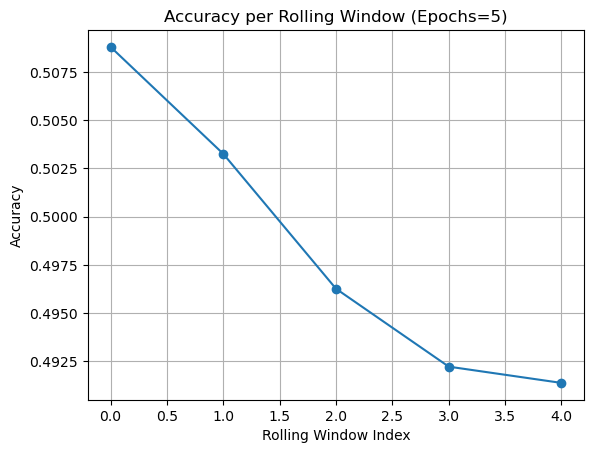

In [5]:
dataset = df[['kmeans_raw_data_label', 'target']].values

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 1])  # target 열을 사용하여 y 값을 추가
    return np.array(X), np.array(y)

# 타임스텝 설정
time_step = 10
X, y = create_dataset(dataset, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Rolling Window Cross-Validation 설정
initial_train_size = int(len(X) * 0.5)  # 초기 훈련 데이터 크기
window_size = int(len(X) * 0.1)  # 슬라이딩 윈도우 크기

accuracy_scores_epoch = []

# 예측 값을 저장할 리스트 초기화
all_predictions = np.full(len(y), np.nan)

# Rolling Window Cross-Validation
for start in range(0, len(X) - initial_train_size, window_size):
    end = start + initial_train_size
    if end + window_size > len(X):
        break  # 데이터 범위를 벗어나면 종료

    X_train, X_val = X[start:end], X[end:end + window_size]
    y_train, y_val = y[start:end], y[end:end + window_size]

    model = create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[early_stopping])
    val_predict = model.predict(X_val)
    val_predict = (val_predict > 0.5).astype(int)
    accuracy = accuracy_score(y_val, val_predict)
    accuracy_scores_epoch.append(accuracy)
    all_predictions[end:end + window_size] = val_predict.flatten()

# 시각화
plt.plot(range(len(accuracy_scores_epoch)), accuracy_scores_epoch, marker='o')
plt.title('Accuracy per Rolling Window (Epochs=5)')
plt.xlabel('Rolling Window Index')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# DataFrame에 새로운 열로 예측 값 추가
df['predictions'] = np.nan
df.loc[time_step + 1:len(all_predictions) + time_step, 'predictions'] = all_predictions

In [6]:
df = df.dropna()

In [7]:
df.rename(inplace=True, columns={"kmeans_raw_data_label": "kmeans_raw_label"})

In [8]:
tt_df = df.copy()
tt_df['cluster'] = tt_df['kmeans_raw_label']
tt_df['price60'] = (tt_df['price'].shift(-60) / tt_df['price'] - 1) * 100
tt_df.dropna(inplace=True)

grouped = tt_df.groupby("cluster")
result_df = pd.DataFrame(grouped.mean().sort_values(by='cluster', ascending=True)['price60'])
result_df = result_df.transpose()

df['kmeans_raw_label2'] = 0
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 4, 1, df['kmeans_raw_label2'])
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 2, 7/8, df['kmeans_raw_label2'])
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 7, 6/8, df['kmeans_raw_label2'])
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 6, 5/8, df['kmeans_raw_label2'])
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 5, 4/8, df['kmeans_raw_label2'])
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 3, 3/8, df['kmeans_raw_label2'])
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 1, 2/8, df['kmeans_raw_label2'])
df['kmeans_raw_label2'] = np.where(df['kmeans_raw_label'] == 0, 1/8, df['kmeans_raw_label2'])

In [9]:
df.to_csv("./result_data/version2.csv")

In [16]:
t_df = df.copy()
t_df['kmeans_raw_label3'] = np.where(t_df['predictions'] == 1, t_df['kmeans_raw_label2'], t_df['kmeans_raw_label2'])
t_df['market_return'] = ((t_df['price'].shift(-1) / t_df['price']).cumprod() - 1) * 100
t_df['kmean_raw_st_return'] = ((1 + (t_df['price'].shift(-1) / t_df['price'] - 1) * (t_df['kmeans_raw_label2'])).cumprod() - 1) * 100
t_df['kmean_raw_st_return2'] = ((1 + (t_df['price'].shift(-1) / t_df['price'] - 1) * (t_df['kmeans_raw_label3'])).cumprod() - 1) * 100
t_df['kmean_raw_st_return2'] = (np.where(t_df['predictions'] == 1, (1 + (t_df['price'].shift(-1) / t_df['price'] - 1) * (t_df['kmeans_raw_label3']) + 0.000001), (1 + (t_df['price'].shift(-1) / t_df['price'] - 1) * (t_df['kmeans_raw_label3']))).cumprod() - 1) * 100

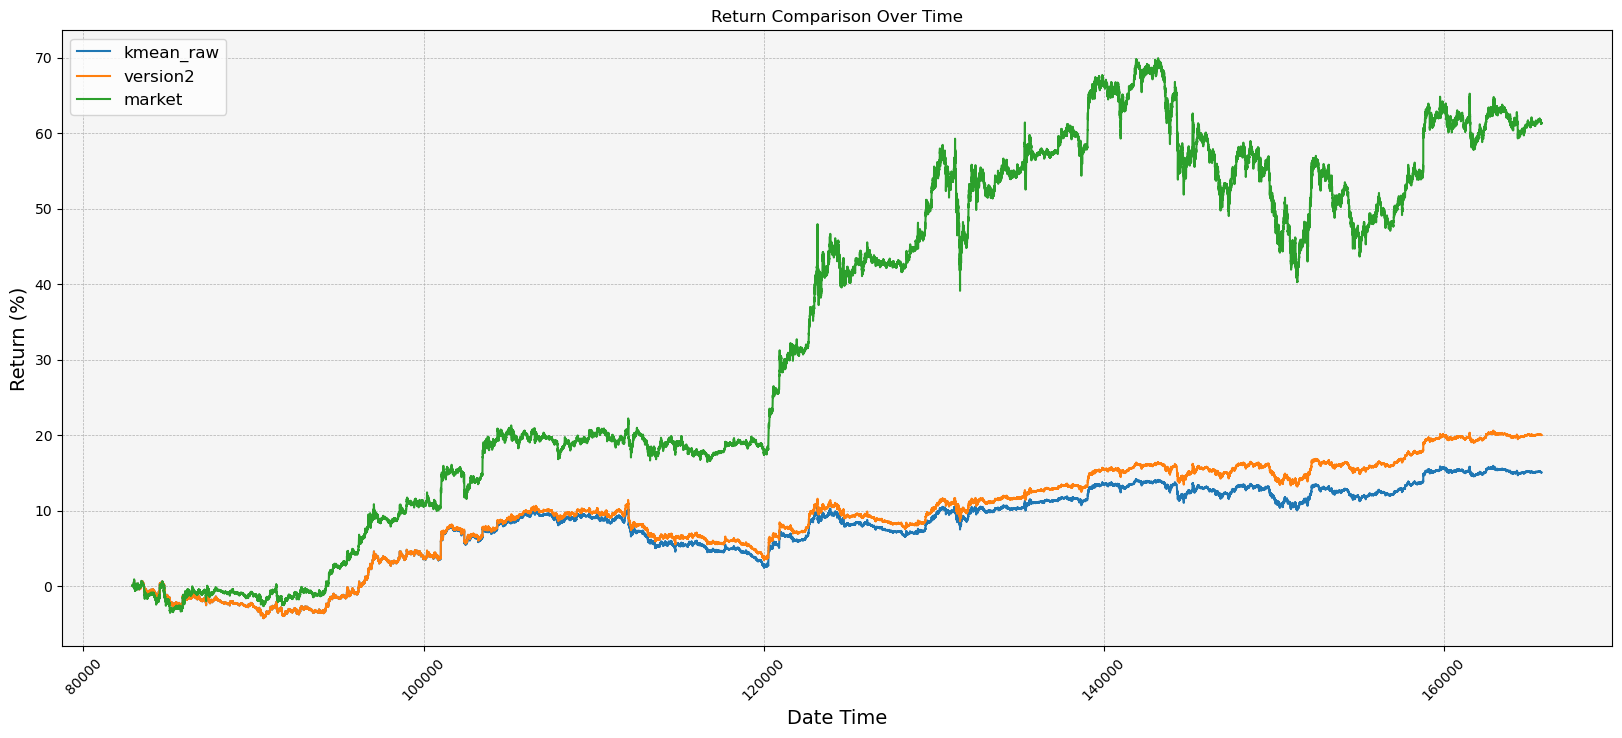

In [17]:
plt.figure(figsize=(20, 8))
plt.title("Return Comparison Over Time")
plt.plot(t_df.index, t_df.kmean_raw_st_return, label="kmean_raw")
plt.plot(t_df.index, t_df.kmean_raw_st_return2, label="version2")
plt.plot(t_df.index, t_df.market_return, label="market")

plt.xlabel('Date Time', fontsize=14)
plt.ylabel('Return (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.gca().set_facecolor('whitesmoke')
plt.show()